In [1]:
import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats

In [2]:
%config InlineBackend.figure_format = 'retina'
%load_ext watermark
az.style.use('arviz-darkgrid')

#### Code 2.1

In [3]:
ways = np.array([0, 3, 8, 9, 0])
ways / ways.sum()

array([0.  , 0.15, 0.4 , 0.45, 0.  ])

#### Code 2.2

$$Pr(w \mid n, p) =  \frac{n!}{w!(n − w)!} p^w (1 − p)^{n−w}$$


The probability of observing six W’s in nine tosses—under a value of p=0.5

In [4]:
stats.binom.pmf(6, n=9, p=0.5)

0.16406250000000006

#### Code 2.3 and 2.5

Computing the posterior using a grid approximation.

In the book the following code is not inside a function, but this way is easier to play with different parameters

In [5]:
def posterior_grid_approx(grid_points=5, success=6, tosses=9):
    """
    """
    # define grid
    p_grid = np.linspace(0, 1, grid_points)

    # define prior
    prior = np.repeat(5, grid_points)  # uniform
    # prior = (p_grid >= 0.5).astype(int)  # truncated
    # prior = np.exp(- 5 * abs(p_grid - 0.5))  # double exp

    # compute likelihood at each point in the grid
    likelihood = stats.binom.pmf(success, tosses, p_grid)

    # compute product of likelihood and prior
    unstd_posterior = likelihood * prior

    # standardize the posterior, so it sums to 1
    posterior = unstd_posterior / unstd_posterior.sum()
    return p_grid, posterior

#### Code 2.3

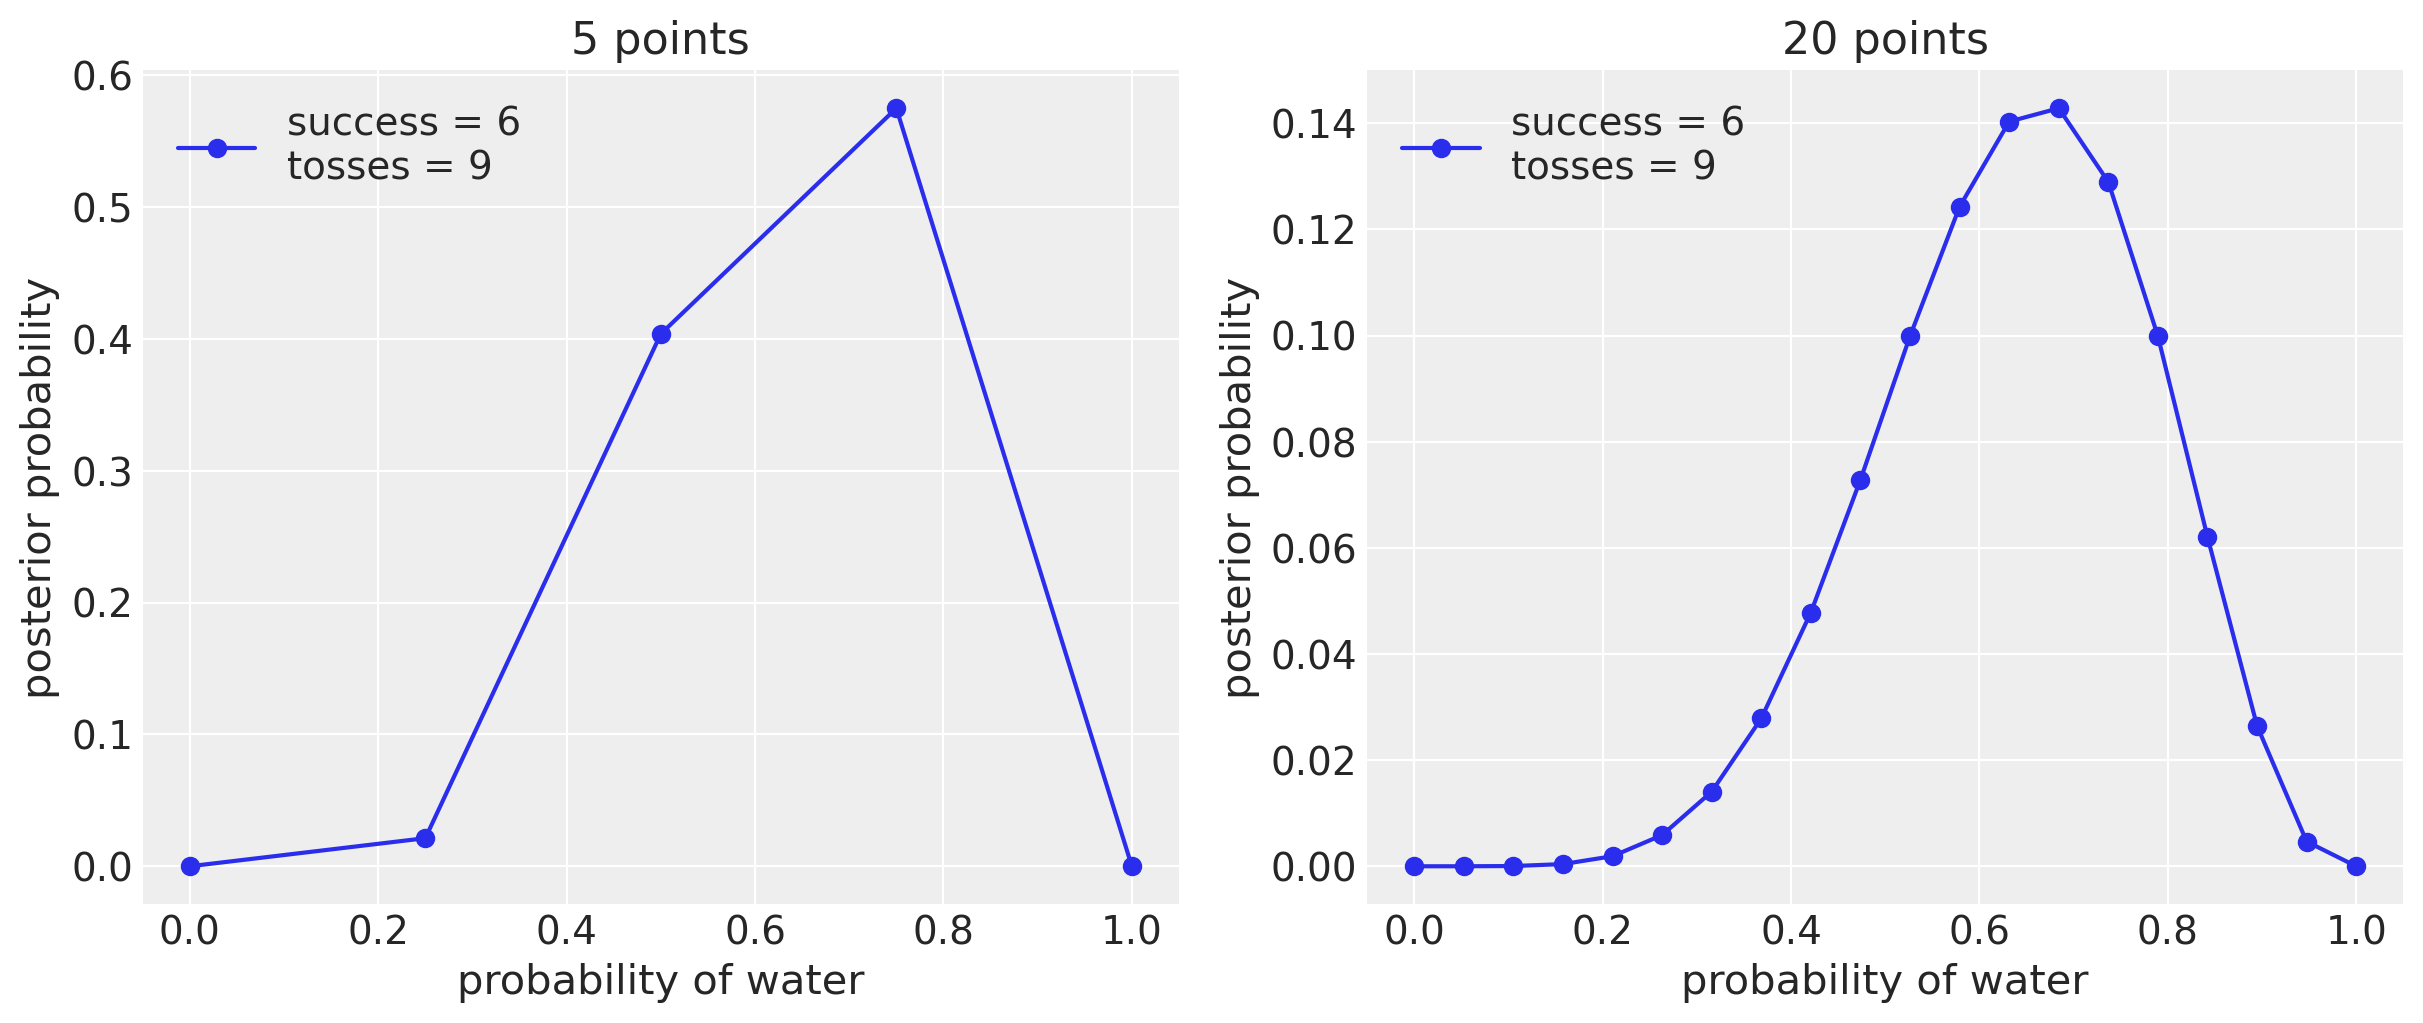

In [6]:
w, n = 6, 9

_, ax = plt.subplots(1, 2, figsize=(12, 5))

points = (5, 20)
for idx, ps in enumerate(points):
    p_grid, posterior = posterior_grid_approx(ps, w, n)
    ax[idx].plot(p_grid, posterior, "o-", label=f"success = {w}\ntosses = {n}")
    ax[idx].set_xlabel("probability of water")
    ax[idx].set_ylabel("posterior probability")
    ax[idx].set_title(f"{ps} points")
    ax[idx].legend(loc=0)

#### Code 2.6

Computing the posterior using the quadratic aproximation

In [7]:
data = pd.DataFrame(np.repeat((0, 1), (3, 6)), columns=['w'])

In [8]:
model = bmb.Model(data=data)

In [9]:
priors = {'Intercept': bmb.Prior('Uniform', lower=0, upper=1)}
results = model.fit('w ~ 1', family='bernoulli', link='identity', 
                    priors=priors, method='laplace')

/home/osvaldo/proyectos/00_BM/Bambi/bambi/bambi/models.py:265: UserWarning: Modeling the probability that w=='1'
  self.y.name, str(self.clean_data[self.y.name].iloc[event])


In [10]:
mode, std = results['Intercept']

In [11]:
norm = stats.norm(mode, std)
prob = 0.89
z = stats.norm.ppf([(1 - prob) / 2, (1 + prob) / 2])
pi = mode + std * z
pi

array([0.41553484, 0.91779849])

#### Code 2.7

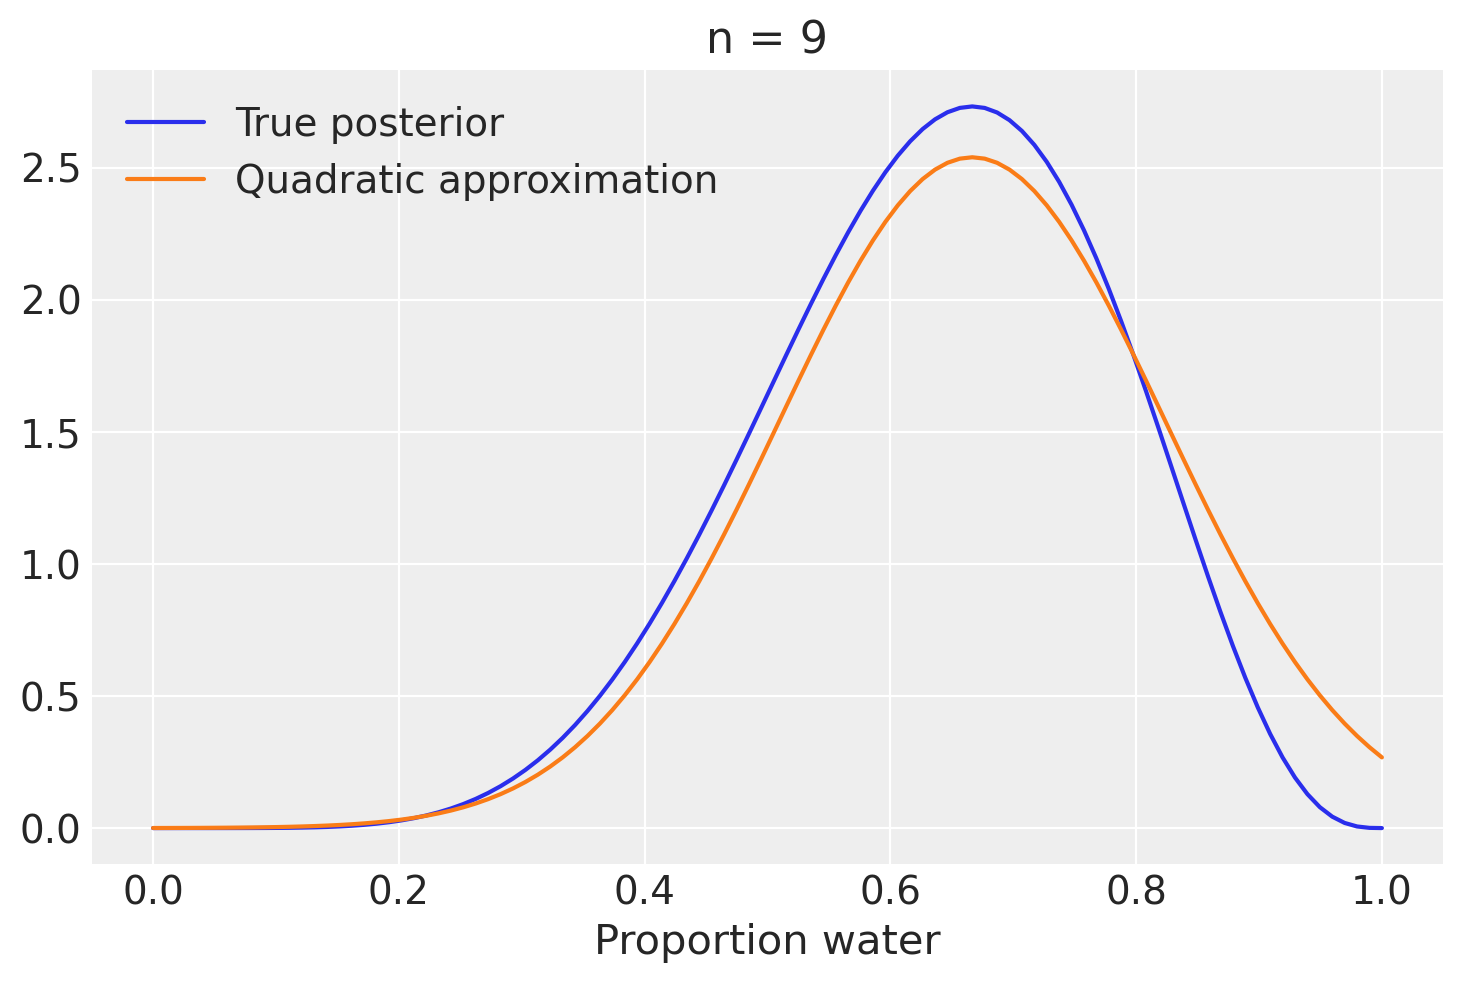

In [12]:
# analytical calculation
w, n = 6, 9
x = np.linspace(0, 1, 100)
plt.plot(x, stats.beta.pdf(x, w + 1, n - w + 1), label="True posterior")

# quadratic approximation
plt.plot(x, stats.norm.pdf(x, mode, std), label="Quadratic approximation")
plt.legend(loc=0)

plt.title(f"n = {n}")
plt.xlabel("Proportion water");

#### Code 2.8

In [13]:
n_samples = 1000
p = np.zeros(n_samples)
p[0] = 0.5
W = 6
L = 3
for i in range(1, n_samples):
    p_new = stats.norm(p[i - 1], 0.1).rvs(1)
    if p_new < 0:
        p_new = -p_new
    if p_new > 1:
        p_new = 2 - p_new
    q0 = stats.binom.pmf(W, n=W + L, p=p[i - 1])
    q1 = stats.binom.pmf(W, n=W + L, p=p_new)
    if stats.uniform.rvs(0, 1) < q1 / q0:
        p[i] = p_new
    else:
        p[i] = p[i - 1]

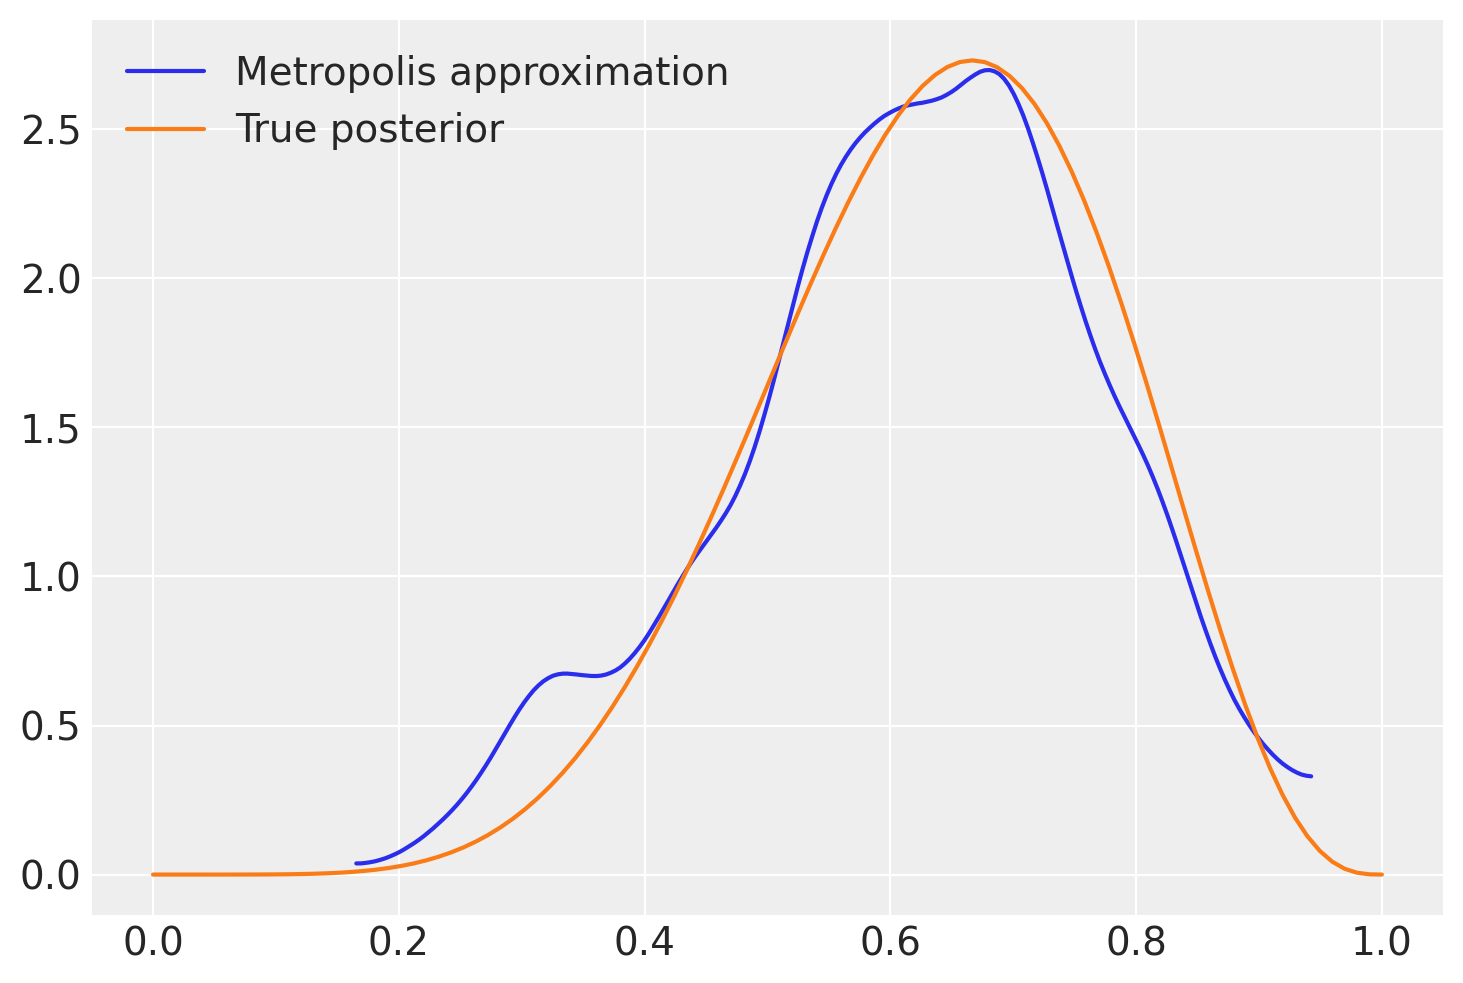

In [14]:
az.plot_kde(p, label="Metropolis approximation")
x = np.linspace(0, 1, 100)
plt.plot(x, stats.beta.pdf(x, W + 1, L + 1), "C1", label="True posterior")
plt.legend();

In [15]:
%watermark -n -u -v -iv -w

pandas   1.0.1
autopep8 1.5
arviz    0.9.0
json     2.0.9
bambi    0.2.0
numpy    1.18.1
last updated: Tue Jun 30 2020 

CPython 3.7.6
IPython 7.12.0
watermark 2.0.2
